In [ ]:
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
import pandas as pd
import os
import json
import sys
import numpy as np

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir)))

from stylesheet import *

In [ ]:
dataset = "FashionMNIST"
dataset = "CIFAR10"

basepath_mnist = "/raid/home/q615005/dev/data_compression/results/grid_search_LinearVQC'_NonLinearVQC_shadow/main_2025-02-10_13-59-51/"
basepath_fashion = "/raid/home/q615005/dev/data_compression/results/grid_search_LinearVQC'_NonLinearVQC_shadow/main_2025-02-12_14-19-20/"
basepath_cifar = "/raid/home/q615005/dev/data_compression/results/grid_search_LinearVQC'_NonLinearVQC_shadow/main_2024-11-08_10-53-59/"

def get_results_dict(experiment: str):
    df = pd.read_csv(os.path.join(experiment, "training_data_epoch.csv"))
    min_loss_val_index = df['loss_val'].idxmin()
    min_loss_val_row = df.loc[min_loss_val_index]

    with open(os.path.join(experiment, "params.json"), "r") as f:
        params = json.load(f)

    config_model = params['config_model']
    config_dataset = params['config_dataset']

    combined_dict = {**config_model, **config_dataset, **min_loss_val_row.to_dict()}

    return combined_dict

dirs = [d for d in os.listdir(basepath_mnist) if os.path.isdir(os.path.join(basepath_mnist, d))]
results_mnist = pd.DataFrame([get_results_dict(basepath_mnist + d) for d in dirs])

dirs = [d for d in os.listdir(basepath_fashion) if os.path.isdir(os.path.join(basepath_fashion, d))]
results_fashion = pd.DataFrame([get_results_dict(basepath_fashion + d) for d in dirs])

dirs = [d for d in os.listdir(basepath_cifar) if os.path.isdir(os.path.join(basepath_cifar, d))]
results_cifar = pd.DataFrame([get_results_dict(basepath_cifar + d) for d in dirs])

results = pd.concat([results_mnist, results_fashion, results_cifar], ignore_index=True)

240
  building_block_tag  depth  epochs  learning_rate                model  \
0                su4      8     100         0.0008            LinearVQC   
1                su4      2     100         0.0008            LinearVQC   
2                su4      5     100         0.0008  NonLinearVQC_shadow   
3                su4      4     100         0.0008  NonLinearVQC_shadow   
4                su4      3     100         0.0008  NonLinearVQC_shadow   

   n_qubits optimizer  temperature  batch_size  compression_depth  \
0        11      ADAM          128         100              False   
1        11      ADAM          128         100              False   
2        11      ADAM          128         100              False   
3        11      ADAM          128         100              False   
4        11      ADAM          128         100              False   

   current_fold dataset_name  n_splits  loss_train  accuracy_train  loss_val  \
0             0        mnist         5    2.243035

Results grouped for MNIST: 
                  model  depth  accuracy_train_mean  accuracy_train_std  \
0             LinearVQC      1             0.825936            0.020428   
1             LinearVQC      2             0.883381            0.004128   
2             LinearVQC      3             0.896465            0.004337   
3             LinearVQC      4             0.909814            0.002399   
4             LinearVQC      5             0.911628            0.003429   
5             LinearVQC      6             0.918945            0.004119   
6             LinearVQC      7             0.918751            0.002826   
7             LinearVQC      8             0.922104            0.003329   
8   NonLinearVQC_shadow      1             0.914855            0.008831   
9   NonLinearVQC_shadow      2             0.944075            0.004872   
10  NonLinearVQC_shadow      3             0.953059            0.003670   
11  NonLinearVQC_shadow      4             0.961928            0.003353 

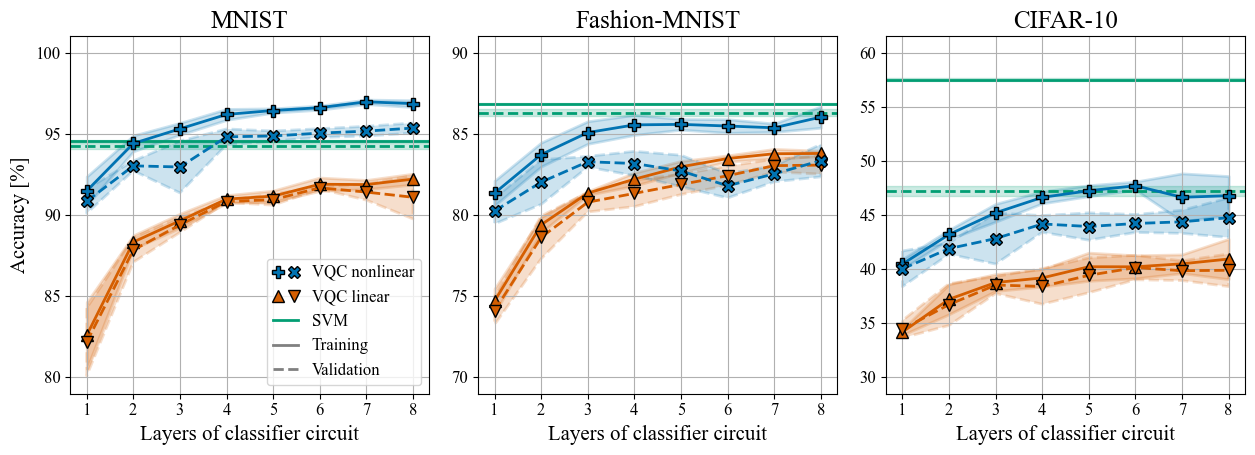

In [8]:
import seaborn as sns


colors = {
    "NonLinearVQC_shadow": color_palette['blue'],
    "LinearVQC": color_palette['red'],
    "SVM": color_palette['green']
}

markers = {
    "LinearVQC_train": "^",
    "LinearVQC_val": "v",
    "NonLinearVQC_shadow_train": "P",
    "NonLinearVQC_shadow_val": "X",
    "SVM": "*",
}

# Filter results for FashionMNIST and CIFAR10
results_fashionmnist = results[results['dataset_name'] == 'fashion_mnist']
results_cifar10 = results[results['dataset_name'] == 'cifar10']
results_mnist = results[results['dataset_name'] == 'mnist']

# Group by model and depth for FashionMNIST
results_grouped_mnist = results_mnist.groupby(['model', 'depth']).agg({
    'accuracy_train': ['mean', 'std'],
    'accuracy_val': ['mean', 'std']
}).reset_index()

svm_baseline = pd.read_csv('/raid/home/q615005/dev/data_compression/results/svm_results_single_patch.csv')

# Flatten the MultiIndex columns for FashionMNIST
results_grouped_mnist.columns = ['model', 'depth', 'accuracy_train_mean', 'accuracy_train_std', 'accuracy_val_mean', 'accuracy_val_std']


# Group by model and depth for FashionMNIST
results_grouped_fashionmnist = results_fashionmnist.groupby(['model', 'depth']).agg({
    'accuracy_train': ['mean', 'std'],
    'accuracy_val': ['mean', 'std']
}).reset_index()

# Flatten the MultiIndex columns for FashionMNIST
results_grouped_fashionmnist.columns = ['model', 'depth', 'accuracy_train_mean', 'accuracy_train_std', 'accuracy_val_mean', 'accuracy_val_std']

# Group by model and depth for CIFAR10
results_grouped_cifar10 = results_cifar10.groupby(['model', 'depth']).agg({
    'accuracy_train': ['mean', 'std'],
    'accuracy_val': ['mean', 'std']
}).reset_index()

# Flatten the MultiIndex columns for CIFAR10
results_grouped_cifar10.columns = ['model', 'depth', 'accuracy_train_mean', 'accuracy_train_std', 'accuracy_val_mean', 'accuracy_val_std']

def plot_results(ax, results_grouped, title, colors, yticks, legend=False):
    ax.set_title(title)
    ax.set_xlabel('Layers of classifier circuit')
    ax.set_xticks(results_grouped['depth'].unique())
    ax.grid(True)
    for model in results_grouped['model'].unique():
        subset = results_grouped[results_grouped['model'] == model]
        sns.lineplot(
            x=subset['depth'],
            y=subset['accuracy_train_mean'] * 100,
            ax=ax,
            marker=markers[model+"_train"],
            color=colors[model],
            linestyle='solid',
            markersize=marker_size,
            linewidth=line_width,
            markeredgewidth=markeredgewidth,
            markeredgecolor='black'
        )
        ax.fill_between(
            subset['depth'],
            (subset['accuracy_train_mean'] - subset['accuracy_train_std']) * 100,
            (subset['accuracy_train_mean'] + subset['accuracy_train_std']) * 100,
            color=colors[model],
            linewidth=line_width,
            alpha=0.2
        )
        sns.lineplot(
            x=subset['depth'],
            y=subset['accuracy_val_mean'] * 100,
            ax=ax,
            marker=markers[model+"_val"],
            color=colors[model],
            linestyle='dashed',
            markersize=marker_size,
            linewidth=line_width,
            markeredgewidth=markeredgewidth,
            markeredgecolor='black'
        )
        ax.fill_between(
            subset['depth'],
            (subset['accuracy_val_mean'] - subset['accuracy_val_std']) * 100,
            (subset['accuracy_val_mean'] + subset['accuracy_val_std']) * 100,
            color=colors[model],
            linestyle='dashed',
            linewidth=line_width,
            alpha=0.2
        )

    print("Results grouped for {}: ".format(title))
    print(results_grouped)

    if legend:
        custom_handles = [
            (plt.Line2D([0], [0],
                        color=colors["NonLinearVQC_shadow"], marker=markers["NonLinearVQC_shadow_train"], linestyle='',
                        markersize=marker_size, markeredgewidth=markeredgewidth, markeredgecolor='black'),
            plt.Line2D([0], [0],
                        color=colors["NonLinearVQC_shadow"], marker=markers["NonLinearVQC_shadow_val"], linestyle='',
                        markersize=marker_size, markeredgewidth=markeredgewidth, markeredgecolor='black')),
            (plt.Line2D([0], [0],
                        color=colors["LinearVQC"], marker=markers["LinearVQC_train"], linestyle='',
                        markersize=marker_size, markeredgewidth=markeredgewidth, markeredgecolor='black'),
            plt.Line2D([0], [0],
                        color=colors["LinearVQC"], marker=markers["LinearVQC_val"], linestyle='',
                        markersize=marker_size, markeredgewidth=markeredgewidth, markeredgecolor='black')),
            plt.Line2D([0], [0],
                    color=colors["SVM"], linestyle='-', linewidth=line_width),
            
            plt.Line2D([0], [0],
                    color='gray', linestyle='-', linewidth=line_width),
            
            plt.Line2D([0], [0],
                    color='gray', linestyle='--', linewidth=line_width)
        ]

        custom_labels = [
            "VQC nonlinear",
            "VQC linear",
            "SVM",
            "Training",
            "Validation"]

        ax.legend(custom_handles, custom_labels, handlelength=handlelength, handler_map={tuple: HandlerTuple(ndivide=None)})
        ax.set_ylabel('Accuracy [%]')
    else:
        ax.set_ylabel("")

    ax.set_yticks(yticks)
    shift = 0.05 * (yticks[-1] - yticks[0])
    ax.set_ylim([yticks[0] - shift, yticks[-1] + shift])
    left, right = ax.get_xlim()
    ax.set_xlim([left, right])

fig, axes = plt.subplots(1, 3, figsize=(12.8, 4.8))
# Add SVM baselines to the plots
plot_results(axes[0], results_grouped_mnist, "MNIST", colors, yticks=[80, 85, 90, 95, 100], legend=True)
plot_results(axes[1], results_grouped_fashionmnist, "Fashion-MNIST", colors, yticks=[70, 75, 80, 85, 90])
plot_results(axes[2], results_grouped_cifar10, "CIFAR-10", colors, yticks=np.arange(30, 61, 5))
for ax, dataset_name in zip(axes, ['mnist', 'fashion_mnist', 'cifar10']):
    baseline = svm_baseline[svm_baseline['dataset'] == dataset_name]
    mean_val_accuracy = baseline['mean_val_accuracy'].values[0] * 100
    std_val_accuracy = baseline['std_val_accuracy'].values[0] * 100
    mean_train_accuracy = baseline['mean_train_accuracy'].values[0] * 100
    std_train_accuracy = baseline['std_train_accuracy'].values[0] * 100

    print(f"Baseline validation accuracy for {dataset_name}: {mean_val_accuracy:.2f}% ± {std_val_accuracy:.2f}%")
    print(f"Baseline validation accuracy for {dataset_name}: {mean_train_accuracy:.2f}% ± {std_train_accuracy:.2f}%")

    # Move SVM plots to the back by plotting them first
    ax.axhline(mean_train_accuracy, color=colors["SVM"], linestyle='-', linewidth=line_width, zorder=1)
    ax.fill_between(
        ax.get_xlim(),
        [mean_train_accuracy - std_train_accuracy] * 2,
        [mean_train_accuracy + std_train_accuracy] * 2,
        color=colors["SVM"],
        alpha=0.2,
        zorder=1
    )
    ax.axhline(mean_val_accuracy, color=colors["SVM"], linestyle='--', linewidth=line_width, zorder=1)
    ax.fill_between(
        ax.get_xlim(),
        [mean_val_accuracy - std_val_accuracy] * 2,
        [mean_val_accuracy + std_val_accuracy] * 2,
        color=colors["SVM"],
        alpha=0.2,
        zorder=1
    )

plt.tight_layout()
plt.savefig('non_linear.pdf')
plt.show()